## Model-fitting

#### Imports

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [23]:
df = pd.read_csv("../data/processed/reddit_emotions_cleaned.csv")
df.head()

,clean_text,subreddit,emotional_score
0,husband doesnt pressure sex spent entire life ...,gratitude,1.0
1,getting sleep divorce comes sleep hygiene husb...,gratitude,1.0
2,get shopping hauls others like used partner di...,gratitude,1.0
3,first meal escaped homelessness able find chea...,gratitude,1.0
4,gratitude didnt fix life made quieter inside u...,gratitude,1.0


In [24]:
df.shape

(3621, 3)

Splitting data and fitting TF-IDF Vectorizer

In [25]:
X = df["clean_text"]
y = df["emotional_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

#### Model fitting (Ridge Regression)

In [27]:
ridge = Ridge()
ridge.fit(X_train_vec, y_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [28]:
y_pred = ridge.predict(X_test_vec)
y_pred = y_pred.clip(0.0, 1.0)

In [29]:
def print_scores(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

In [30]:
def plot_preds(y_test, y_pred):
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
    plt.xlabel("Actual Score")
    plt.ylabel("Predicted Score")
    plt.title("Predicted vs Actual Emotional Scores")
    plt.plot([0,1],[0,1], color='red')
    plt.show()

In [31]:
print_scores(y_test, y_pred)

MSE: 0.0475
MAE: 0.1696
R²: 0.5836


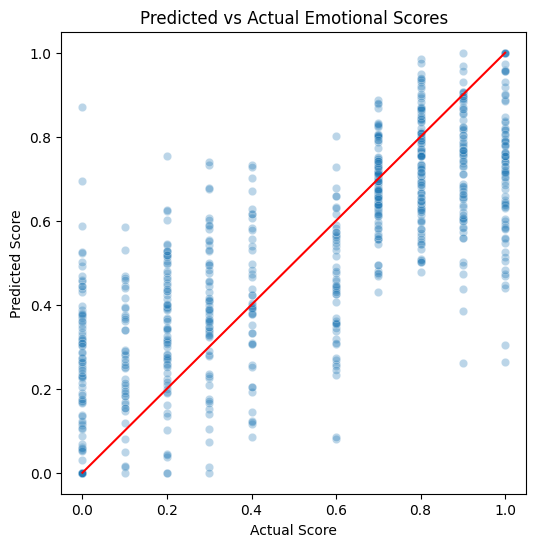

In [32]:
plot_preds(y_test, y_pred)

Model Fitting (Random Forest Regressor)

In [33]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train_vec, y_train)
y_pred_rfr = rfr.predict(X_test_vec)

In [34]:
print_scores(y_test, y_pred_rfr)

MSE: 0.0550
MAE: 0.1628
R²: 0.5177


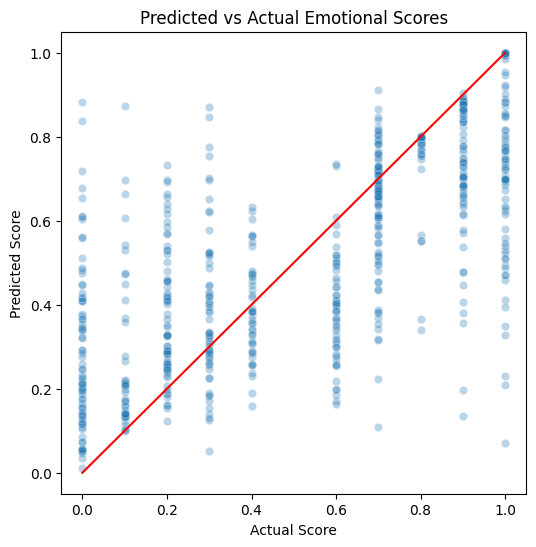

In [35]:
plot_preds(y_test, y_pred_rfr)


#### Hyperparameter Tuning

In [36]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    # 'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

In [37]:
grid_search = GridSearchCV(
    estimator=rfr,
    param_grid=param_grid,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_vec, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], 'n_estimators': [100, 200]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,2
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [38]:
print("Best Params:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test_vec)
y_pred_tuned = y_pred_tuned.clip(0.0, 1.0)

Best Params: {'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [39]:
print_scores(y_test, y_pred_tuned)

MSE: 0.0542
MAE: 0.1617
R²: 0.5243


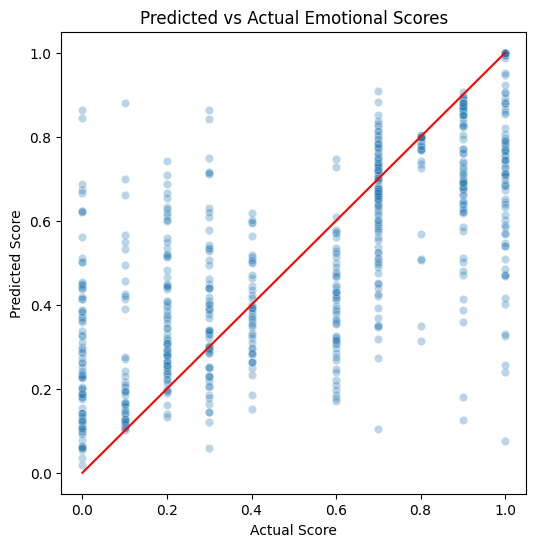

In [40]:
plot_preds(y_test, y_pred_tuned)

#### Saving Model

In [41]:
import pickle

with open("../models/rfr_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

with open("../models/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("../models/ridge_model.pkl", "wb") as f:
    pickle.dump(ridge, f)

#### Logging into MLFlow


In [42]:
import mlflow
import mlflow.sklearn

In [43]:
mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("Emotional State Prediction")

<Experiment: artifact_location='file:d:/emotional-state-predictor/notebooks/../mlruns/239915684543966521', creation_time=1750872116949, experiment_id='239915684543966521', last_update_time=1750872116949, lifecycle_stage='active', name='Emotional State Prediction', tags={}>

In [44]:
with mlflow.start_run(run_name="TFIDF + Tuned RandomForest"):

    # Model and vectorizer type
    mlflow.log_param("model_type", "RandomForestRegressor")
    mlflow.log_param("vectorizer", "TfidfVectorizer")

    # Best hyperparameters
    mlflow.log_param("n_estimators", best_model.get_params()["n_estimators"])
    mlflow.log_param("min_samples_split", best_model.get_params()["min_samples_split"])
    mlflow.log_param("min_samples_leaf", best_model.get_params()["min_samples_leaf"])

    # Metrics
    mlflow.log_metric("mse", mean_squared_error(y_test, y_pred_tuned))
    mlflow.log_metric("mae", mean_absolute_error(y_test, y_pred_tuned))
    mlflow.log_metric("r2", r2_score(y_test, y_pred_tuned))

    # Model and vectorizer files
    mlflow.log_artifact("../models/rfr_model.pkl", artifact_path="model")
    mlflow.log_artifact("../models/vectorizer.pkl", artifact_path="vectorizer")

In [45]:
with mlflow.start_run(run_name="TFIDF + Ridge Regression"):

    # Model and vectorizer type
    mlflow.log_param("model_type", "RidgeRegressor")
    mlflow.log_param("vectorizer", "TfidfVectorizer")

    # Best hyperparameters
    mlflow.log_param("alpha", ridge.get_params()["alpha"])

    # Metrics
    mlflow.log_metric("mse", mean_squared_error(y_test, y_pred))
    mlflow.log_metric("mae", mean_absolute_error(y_test, y_pred))
    mlflow.log_metric("r2", r2_score(y_test, y_pred))

    # Model and vectorizer files
    mlflow.log_artifact("../models/ridge_model.pkl", artifact_path="model")
    mlflow.log_artifact("../models/vectorizer.pkl", artifact_path="vectorizer")

### UPDATE: 
Support Vector Regressor in place of Random Forest Regressor

In [46]:
from sklearn.svm import SVR

In [47]:
svr = SVR()

svr.fit(X_train_vec, y_train)
y_pred_svr = svr.predict(X_test_vec)

In [48]:
print_scores(y_test, y_pred_svr)

MSE: 0.0519
MAE: 0.1857
R²: 0.5444


#### Hyperparameter Tuning

In [49]:
param_grid_svr = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2]
}

grid_svr = GridSearchCV(
    estimator=svr,
    param_grid=param_grid_svr,
    scoring='neg_mean_squared_error',
    cv=2,
    verbose=1,
    n_jobs=-1
)

grid_svr.fit(X_train_vec, y_train)

print("Best SVR Params:", grid_svr.best_params_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
Best SVR Params: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'linear'}


In [50]:
param_grid_svr = {
    'kernel': ['linear', 'rbf'],
    'C': [0.05, 0.1, 0.2],
    'epsilon': [0.005, 0.01, 0.02]
}

grid_svr = GridSearchCV(
    estimator=svr,
    param_grid=param_grid_svr,
    scoring='neg_mean_squared_error',
    cv=2,
    verbose=1,
    n_jobs=-1
)

grid_svr.fit(X_train_vec, y_train)

print("Best SVR Params:", grid_svr.best_params_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
Best SVR Params: {'C': 0.2, 'epsilon': 0.02, 'kernel': 'linear'}


In [51]:
best_svr = grid_svr.best_estimator_
y_pred_svr_tuned = best_svr.predict(X_test_vec)
y_pred_svr_tuned = y_pred_svr_tuned.clip(0.0, 1.0)

print_scores(y_test, y_pred_svr_tuned)

MSE: 0.0485
MAE: 0.1713
R²: 0.5748


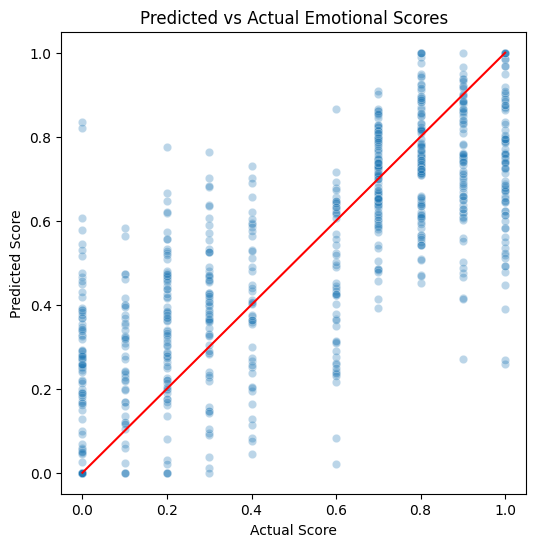

In [52]:
plot_preds(y_test, y_pred_svr_tuned)

In [53]:
with open("../models/svr_model.pkl", "wb") as f:
    pickle.dump(best_svr, f)

In [54]:
with mlflow.start_run(run_name="TFIDF + Tuned SVR"):

    mlflow.log_param("model_type", "SVR")
    mlflow.log_param("vectorizer", "TfidfVectorizer")

    # Best hyperparameters
    mlflow.log_param("kernel", best_svr.get_params()["kernel"])
    mlflow.log_param("C", best_svr.get_params()["C"])
    mlflow.log_param("epsilon", best_svr.get_params()["epsilon"])

    # Evaluation metrics
    mlflow.log_metric("mse", mean_squared_error(y_test, y_pred_svr))
    mlflow.log_metric("mae", mean_absolute_error(y_test, y_pred_svr))
    mlflow.log_metric("r2", r2_score(y_test, y_pred_svr))

    # Save model file
    mlflow.log_artifact("../models/svr_model.pkl", artifact_path="model")
    mlflow.log_artifact("../models/vectorizer.pkl", artifact_path="vectorizer")